In [1]:
import sys
sys.path.append('../../..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn import preprocessing
from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
from sklearn.model_selection import train_test_split


from utils.preprocessing import *
import core.config as conf

## Load data 

In [2]:
train_data_path = conf.dataset_path + 'part-210204-2'
train_df = read_data(train_data_path)

In [3]:
train_df.head()

,text_tokens,hashtags,tweet_id,media,links,domains,tweet_type,language,tweet_timestamp,creator_id,...,engager_id,engager_follower_count,engager_following_count,engager_is_verified,engager_account_creation,creator_follows_engager,reply_timestamp,retweet_timestamp,comment_timestamp,like_timestamp
0,101\t56898\t137\t146\t92317\t80092\t10341\t101...,43A368EE393CD9AFD640D8E9D97F9117\tF7DAF7DDB9A9...,A7EAACD487F59B850B49F6F694261887,Video,NaN,NaN,Retweet,488B32D24BD4BB44172EB981C1BCA6FA,1612451187,375D72BD560D848C2D5425130DD35CD2,...,9F191E0EF45CC3491FC7AD1C29D203B9,128,450,False,1425269499,True,NaN,1.612454e+09,NaN,1.612454e+09
1,101\t14120\t131\t120\t120\t188\t119\t11170\t12...,NaN,9F128BDCF151A483EF11EB319473BE44,Photo\tPhoto,NaN,NaN,TopLevel,313ECD3A1E5BB07406E4249475C2D6D6,1612443885,C02B819378BD51A39B6341E4017FF481,...,82FBB3B5150270FBFC4AC0EAAA6A541E,10,646,False,1544363412,False,NaN,NaN,NaN,NaN
2,101\t56898\t137\t147\t92161\t32792\t44026\t381...,NaN,F8AB716F01EF3B2E3D07A62A30347B5C,NaN,NaN,NaN,Retweet,9FCF19233EAD65EA6E32C2E6DC03A444,1612427814,E68E0C6533173D179FF4E867027AF68D,...,04FCA727D001288BAD09B48C80EC4F77,132,226,False,1549597072,False,NaN,1.612428e+09,NaN,NaN
3,101\t10117\t108\t10339\t20799\t10943\t60036\t1...,0ED93216A8842FECE9F5ADA917FC159A,784A93DE671CA4D15286A09C8124C6AB,Photo\tPhoto\tPhoto\tPhoto,NaN,NaN,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,1612412744,9C7E5A54E672CC8278B25F1FBF4F910B,...,181F3FE296817603354FF850B885EEF8,75,193,False,1570785840,False,NaN,NaN,NaN,1.612417e+09
4,101\t56898\t137\t19556\t10237\t11355\t19986\t1...,NaN,D0C06B49E844FBD9C64F938759A2E5FF,NaN,NaN,NaN,Retweet,488B32D24BD4BB44172EB981C1BCA6FA,1612482791,EC601AB42FE914EDE8EC092714AAE38B,...,72063E9607EE7B14CCB24CBCF0B1FE90,958,196,False,1585271012,True,NaN,NaN,NaN,NaN


In [4]:
val_data_path = conf.dataset_path + 'part-210205-2'
val_df = read_data(val_data_path)

In [5]:
val_df.head()

,text_tokens,hashtags,tweet_id,media,links,domains,tweet_type,language,tweet_timestamp,creator_id,...,engager_id,engager_follower_count,engager_following_count,engager_is_verified,engager_account_creation,creator_follows_engager,reply_timestamp,retweet_timestamp,comment_timestamp,like_timestamp
0,101\t56898\t137\t65525\t10107\t11403\t10371\t2...,NaN,85F1FFFA93D5161FF07EC7B8F0B406FF,Video,NaN,NaN,Retweet,313ECD3A1E5BB07406E4249475C2D6D6,1612492878,A9A7AB7013472F26F3A94F8E193A1926,...,2013F7CC05384F87D2875457A6E7FDCE,27,327,False,1547931541,False,NaN,NaN,NaN,NaN
1,101\t56898\t137\t27857\t12495\t10129\t131\t129...,NaN,D35674D95A5EC6DCD864BDB13DC29582,NaN,NaN,NaN,Retweet,488B32D24BD4BB44172EB981C1BCA6FA,1612494068,4CC01897A2ED30744F1D84E355C851B9,...,F0B4C7ADA498499C42A56CC9F80CA3EA,85,542,False,1454203168,False,NaN,1.612495e+09,NaN,1.612495e+09
2,101\t11583\t103612\t10126\t87438\t11382\t12368...,64C8C491E6948B2AD853EFC58D617BB1\tACD021413735...,7A778553D9B17978E4535C4ED73C15C4,Photo,NaN,NaN,TopLevel,B0FA488F2911701DD8EC5B1EA5E322D8,1612553824,D385E0F308A669ED5832B8BB9234DF6E,...,46E5C38B54B12EFD62D5D38E59763041,317,720,False,1596381015,True,NaN,NaN,NaN,NaN
3,101\t56898\t137\t12034\t11924\t90712\t168\t677...,NaN,15B33D8BC628AD38AA2DFCF545B9C8CB,NaN,NaN,NaN,Retweet,E7F038DE3EAD397AEC9193686C911677,1612485456,2B56D9FAA5B6F8CC89FED5C766D3ED4C,...,6D98A96B53BBD2838C260ABA46B5D7B2,1291,1455,False,1408497790,False,NaN,NaN,NaN,NaN
4,101\t137\t78276\t14601\t19325\t10758\t67257\t1...,NaN,A83C158FD0BC0BC65BD1F9935ABCBE42,NaN,NaN,NaN,TopLevel,B8B04128918BBF54E2E178BFF1ABA833,1612545731,B0435C5E1B79851434535266215FFC06,...,F8FF4BDAD97703433122EACFF8E54C8F,1178,1662,False,1530984899,True,NaN,NaN,NaN,1.612546e+09


In [6]:
train_df.columns

Index(['text_tokens', 'hashtags', 'tweet_id', 'media', 'links', 'domains',
       'tweet_type', 'language', 'tweet_timestamp', 'creator_id',
       'creator_follower_count', 'creator_following_count',
       'creator_is_verified', 'creator_account_creation', 'engager_id',
       'engager_follower_count', 'engager_following_count',
       'engager_is_verified', 'engager_account_creation',
       'creator_follows_engager', 'reply_timestamp', 'retweet_timestamp',
       'comment_timestamp', 'like_timestamp'],
      dtype='object')

In [7]:
used_features = ['engager_follower_count', 
                'engager_following_count', 
                'engager_is_verified', 
                'engager_account_creation', 
                'creator_follower_count', 
                'creator_following_count', 
                'creator_is_verified', 
                'creator_account_creation']

In [8]:
X_train = train_df[used_features]
Y_train = train_df['like_timestamp'].fillna(0).apply(lambda x: 1 if x > 0 else 0)

In [15]:
X_val = val_df[used_features]
Y_val = val_df['like_timestamp'].fillna(0).apply(lambda x: 1 if x > 0 else 0)

In [17]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5)


## Parameters

In [11]:
MODEL_NAME = 'autoencoder_test'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1 

## Preprocessing

In [19]:
def scaling(df_x):
    standard_scaler = preprocessing.StandardScaler()
    standard_scaler.fit(df_x.values)
    ss = standard_scaler.transform(df_x.values)
    df_x = pd.DataFrame(ss, columns = df_x.columns)
    return df_x

In [20]:
X_train = scaling(X_train)
X_val = scaling(X_val)
X_test = scaling(X_test)

In [21]:
X_train

,engager_follower_count,engager_following_count,engager_is_verified,engager_account_creation,creator_follower_count,creator_following_count,creator_is_verified,creator_account_creation
0,-0.058012,-0.152302,-0.043201,-0.439665,-0.162231,-0.108148,-0.492376,0.244745
1,-0.067811,-0.044123,-0.043201,0.604707,-0.161549,-0.111942,-0.492376,1.016462
2,-0.057680,-0.275936,-0.043201,0.650603,-0.161201,-0.110928,-0.492376,-0.183781
3,-0.062413,-0.294149,-0.043201,0.836414,-0.065932,-0.095805,2.030967,-0.823107
4,0.010912,-0.292494,-0.043201,0.963439,-0.162310,-0.106615,-0.492376,-0.079970
...,...,...,...,...,...,...,...,...
9038409,-0.031024,0.480767,-0.043201,-0.588255,-0.160980,-0.100119,-0.492376,1.053424
9038410,-0.062579,-0.355966,-0.043201,0.931642,-0.160286,-0.109369,-0.492376,0.126919
9038411,-0.007025,-0.197009,-0.043201,0.558533,-0.162264,-0.105420,-0.492376,-0.096462
9038412,-0.061915,-0.231781,-0.043201,1.012301,-0.162127,-0.109109,-0.492376,0.466135


## Model

### Encoder Layer

In [132]:

kargs = {
    'model_name': 'auto_encoder',
    'input_dim' : X_train.shape[1],
    'engager_dim' : 4,
    'creator_dim' : 4,
    'embedding_dim': 32,
    'encoder_dim': 64,
    'decoder_dim': 1
    
}


In [137]:
class AutoEncoder(tf.keras.models.Model):
    def __init__(self, **kargs):
        super(AutoEncoder, self).__init__()
        
        self.input_dim = kargs['input_dim']
        self.engager_dim = kargs['engager_dim']
        self.creator_dim = kargs['creator_dim']
        self.embedding_dim = kargs['embedding_dim']
        self.encoder_dim = kargs['encoder_dim']
        self.decoder_dim = kargs['decoder_dim']
        
        # self.engager_embedding = tf.keras.layers.Embedding(input_dim=self.engager_dim, output_dim=self.embedding_dim)
        # self.creator_embedding = tf.keras.layers.Embedding(input_dim=self.creator_dim, output_dim=self.embedding_dim)
    
        self.engager_encoder = tf.keras.layers.Dense(32, activation = 'relu')
        self.creator_encoder = tf.keras.layers.Dense(32, activation = 'relu')
        self.decoder = tf.keras.layers.Dense(1, activation = 'relu')
    
    def call(self, x):
        # x1 = self.engager_embedding(x[:,:4])
        # x2 = self.creator_embedding(x[:,4:])
        # input1 = tf.dtypes.cast(x[:, :4], tf.float32) 
        # input2 = tf.dtypes.cast(x[:, 4:], tf.float32) 
        # x = tf.concat([x1, x2], 1)
        x1 = self.engager_encoder(x[:,:4])
        x2 = self.creator_encoder(x[:,4:])
        x = tf.concat([x1, x2], 1)
        x = self.decoder(x)
        return x

    def summary(self):
        inputs = tf.keras.layers.Input((self.input_dim))
        tf.keras.models.Model(inputs, self.call(inputs)).summary()
    

In [138]:
model = AutoEncoder(**kargs)


In [139]:
model.summary()
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy', 'accuracy'])

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 8)]          0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_42 (Sl (None, 4)            0           input_20[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_43 (Sl (None, 4)            0           input_20[0][0]                   
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 32)           160         tf.__operators__.getitem_42[0][0]
___________________________________________________________________________________________

In [142]:
result = model.fit(
    x = X_train.to_numpy(),
    y = Y_train.to_numpy(),
    validation_data=(X_val.to_numpy(), Y_val.to_numpy()),
    epochs=5,
    batch_size=128
)

Epoch 1/5
70613/70613 [==============================] - 37s 510us/step - loss: 0.6976 - binary_crossentropy: 0.6976 - accuracy: 0.6099 - val_loss: 0.6689 - val_binary_crossentropy: 0.6689 - val_accuracy: 0.6176
Epoch 2/5
70613/70613 [==============================] - 36s 507us/step - loss: 0.6713 - binary_crossentropy: 0.6713 - accuracy: 0.6129 - val_loss: 0.6611 - val_binary_crossentropy: 0.6611 - val_accuracy: 0.6155
Epoch 3/5
70613/70613 [==============================] - 36s 505us/step - loss: 0.6634 - binary_crossentropy: 0.6634 - accuracy: 0.6130 - val_loss: 0.6596 - val_binary_crossentropy: 0.6596 - val_accuracy: 0.6202
Epoch 4/5
70613/70613 [==============================] - 35s 495us/step - loss: 0.6633 - binary_crossentropy: 0.6633 - accuracy: 0.6146 - val_loss: 0.6610 - val_binary_crossentropy: 0.6610 - val_accuracy: 0.6153
Epoch 5/5
70613/70613 [==============================] - 36s 504us/step - loss: 0.6632 - binary_crossentropy: 0.6632 - accuracy: 0.6129 - val_loss: 0.66

## Evaluate

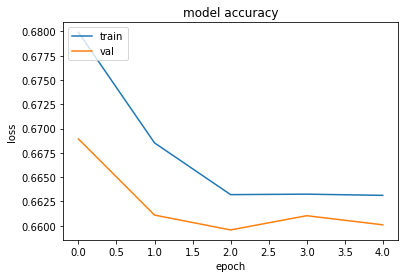

In [143]:
plt.plot(result.history['binary_crossentropy'])
plt.plot(result.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [145]:
pred = model.predict(X_test)

In [146]:
pred.reshape(-1)

array([0.44752303, 0.40583885, 0.39904836, ..., 0.33186802, 0.3550128 ,
       0.44421884], dtype=float32)

In [147]:
Y_val.values.astype(np.float32)

array([0., 1., 0., ..., 1., 0., 0.], dtype=float32)

In [151]:
Y_test.astype(np.float32)

3225616    1.0
688388     0.0
4305574    1.0
6519135    0.0
3259277    0.0
          ... 
5969287    0.0
3343019    0.0
4520640    0.0
5636854    1.0
4155345    0.0
Name: like_timestamp, Length: 4343097, dtype: float32

In [153]:
np.array(Y_test)

array([1, 0, 1, ..., 0, 1, 0])

In [156]:
rce = compute_rce(pred.reshape(-1).astype(np.float64), Y_test.astype(np.float64))
rce

0.8834756748826389

In [150]:
average_precision_score(Y_test, pred)

0.44045349310523785